In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Visualization
import matplotlib.pyplot as plt
import graphviz

# Time series
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.utilities.dataframe_functions import impute
import eli5
from eli5.sklearn import PermutationImportance

/Users/dan/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
2024-03-05 06:01:35.038416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- We first import the database of hospital data alone to do some EDA and see if it can predict closure on its own:

In [2]:
all_hospitals = pd.read_csv('../data/HospitalAttributes.csv')
all_hospitals

,HID,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,...,Medicare Payment,# of Beds,ClosureMonth,ClosureYear,Converted,HasClosed,HospitalType,HasEmergencyServices,HasBirthingFriendlyDesignation,GEOID
0,H010006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO,FLORENCE,AL,35631-,3607186.0,0.0,985.60,358.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,1.0,1.0,1077
1,H010011,ST. VINCENTS EAST,50 MEDICAL PARK DRIVE EAST,BIRMINGHAM,AL,35235-,1713414.0,1381721.0,1119.44,279.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,1.0,0.0,1073
2,H010023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116-,10808215.0,2678762.0,1712.00,363.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,1.0,1.0,1101
3,H010025,GEORGE H. LANIER HOSPITAL,4800 48TH STREET,VALLEY,AL,36854-,1062906.0,0.0,330.86,84.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1017
4,H010027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,AL,35323,103634.0,0.0,97.68,20.0,...,MDH,20.0,February,2013.0,1.0,1.0,NaN,NaN,NaN,1031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75940,H523030,REHABILITATION HOSPITAL OF WESTERN W,900 WEST CLAIREMONT AVENUE 8TH FL,EAU CLAIRE,WI,54701-6122,0.0,0.0,89.78,36.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,55035
75941,H523031,GREEN BAY REHABILITATION HOSPITAL,1110 KEPLER DRIVE,GREEN BAY,WI,54311,0.0,0.0,66.24,40.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,55009
75942,H530034,SUMMIT MEDICAL CENTER LLC,6350 E 2ND STREET,CASPER,WY,82609,0.0,0.0,43.63,16.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,0.0,0.0,56025
75943,H673073,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,71.91,36.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,48183


- Make a datafrome for hospitals which have closed:

In [3]:
closed = all_hospitals[all_hospitals['HasClosed'] == 1]
closed

,HID,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,...,Medicare Payment,# of Beds,ClosureMonth,ClosureYear,Converted,HasClosed,HospitalType,HasEmergencyServices,HasBirthingFriendlyDesignation,GEOID
4,H010027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,AL,35323,103634.0,0.0,97.68,20.0,...,MDH,20.0,February,2013.0,1.0,1.0,NaN,NaN,NaN,1031
8,H010043,CHILTON MEDICAL CENTER,1010 LAY DAM ROAD,CLANTON,AL,35045,41297.0,0.0,117.98,27.0,...,PPS,27.0,November,2012.0,0.0,1.0,NaN,NaN,NaN,1021
14,H010066,FLORALA COMMUNITY HOSPITAL,515 EAST 5TH AVENUE,FLORALA,AL,36442,27474.0,0.0,29.11,22.0,...,PPS,22.0,December,2013.0,1.0,1.0,NaN,NaN,NaN,1039
40,H021303,SITKA COMMUNITY HOSPITAL,209 MOLLER AVENUE,SITKA,AK,99835-,0.0,0.0,148.55,11.0,...,CAH,12.0,July,2019.0,1.0,1.0,NaN,NaN,NaN,2220
58,H030055,KINGMAN REGIONAL MEDICAL CENTER,3269 STOCKTON HILL ROAD,KINGMAN,AZ,86401,3414519.0,1808760.0,1255.87,167.0,...,PPS,70.0,September,2011.0,1.0,1.0,Acute Care Hospitals,1.0,1.0,4015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73968,H360156,MEMORIAL HOSPITAL,715 SOUTH TAFT AVENUE,FREMONT,OH,43420,70373.0,0.0,277.74,31.0,...,PPS,8.0,March,2012.0,1.0,1.0,Acute Care Hospitals,1.0,1.0,39143
74347,H390071,LOCK HAVEN HOSPITAL,24 CREE DRIVE,LOCK HAVEN,PA,17745,8955.0,0.0,106.57,25.0,...,MDH,25.0,March,2023.0,1.0,1.0,Acute Care Hospitals,1.0,0.0,42035
74736,H440007,UNITY MEDICAL CENTER,481 INTERSTATE DRIVE,MANCHESTER,TN,37555,102675.0,0.0,170.02,49.0,...,PPS,53.0,July,2015.0,0.0,1.0,Acute Care Hospitals,1.0,0.0,47031
75770,H670004,ST. MARKS MEDICAL CENTER,ONE ST. MARKS PLACE,LA GRANGE,TX,78945,0.0,0.0,141.09,38.0,...,REH,0.0,October,2023.0,0.0,1.0,NaN,NaN,NaN,48149


In [4]:
closed.sort_values(by='HID')

,HID,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,...,Medicare Payment,# of Beds,ClosureMonth,ClosureYear,Converted,HasClosed,HospitalType,HasEmergencyServices,HasBirthingFriendlyDesignation,GEOID
2332,H010015,SOUTHWEST ALABAMA MEDICAL CENTER,33400 HIGHWAY 43 NORTH,THOMASVILLE,AL,36784-,9767.0,0.0,75.03,27.0,...,PPS,27.0,August,2011.0,0.0,1.0,NaN,NaN,NaN,1025
4,H010027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,AL,35323,103634.0,0.0,97.68,20.0,...,MDH,20.0,February,2013.0,1.0,1.0,NaN,NaN,NaN,1031
8486,H010027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,AL,35323,12764.0,0.0,89.40,20.0,...,MDH,20.0,February,2013.0,1.0,1.0,NaN,NaN,NaN,1031
2341,H010027,ELBA GENERAL HOSPITAL,987 DRAYTON STREET,ELBA,AL,35323,48548.0,0.0,159.60,20.0,...,MDH,20.0,February,2013.0,1.0,1.0,NaN,NaN,NaN,1031
8,H010043,CHILTON MEDICAL CENTER,1010 LAY DAM ROAD,CLANTON,AL,35045,41297.0,0.0,117.98,27.0,...,PPS,27.0,November,2012.0,0.0,1.0,NaN,NaN,NaN,1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70094,H670004,ST. MARKS MEDICAL CENTER,ONE ST. MARKS PLACE,LA GRANGE,TX,78945,0.0,0.0,139.37,38.0,...,REH,0.0,October,2023.0,0.0,1.0,NaN,NaN,NaN,48149
20857,H670004,ST. MARKS MEDICAL CENTER,ONE ST. MARKS PLACE,LA GRANGE,TX,78945,103717.0,0.0,181.78,44.0,...,REH,0.0,October,2023.0,0.0,1.0,NaN,NaN,NaN,48149
14643,H670052,NORTH TEXAS COMMUNITY HOSPITAL,1905 DOCTORS HOSPITAL DRIVE,BRIDGEPORT,TX,79426,179413.0,0.0,140.15,36.0,...,PPS,36.0,December,2013.0,1.0,1.0,NaN,NaN,NaN,48497
20881,H670052,NORTH TEXAS COMMUNITY HOSPITAL,1905 DOCTORS HOSPITAL DRIVE,BRIDGEPORT,TX,79426,33990.0,0.0,128.39,36.0,...,PPS,36.0,December,2013.0,1.0,1.0,NaN,NaN,NaN,48497


- Sample an equal amount of rows from hospitals which have not closed:

In [5]:
not_closed2 = all_hospitals[all_hospitals['HasClosed'] == 0]
not_closed2 = not_closed2.sample(n=closed.shape[0])#, random_state=1)
not_closed2

,HID,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,...,Medicare Payment,# of Beds,ClosureMonth,ClosureYear,Converted,HasClosed,HospitalType,HasEmergencyServices,HasBirthingFriendlyDesignation,GEOID
72076,H170203,MERCY SPECIALTY HOSPITAL - SOUTHEAST,1619 K 66,GALENA,KS,66739,0.0,0.0,129.38,26.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,0.0,0.0,20021
8028,H491304,CARILION STONEWALL JACKSON HOSPITAL,1 HEALTH CIRCLE,LEXINGTON,VA,24450,0.0,0.0,195.64,25.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Critical Access Hospitals,1.0,0.0,51678
68683,H392028,CURAHEALTH PITTSBURGH,7777 STEUBENVILLE PIKE,OAKDALE,PA,15071,0.0,0.0,48.04,63.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,42003
44466,H423026,HEALTHSOUTH REHABILITATION HOSPITAL,900 EAST CHEVES STREET,FLORENCE,SC,29506,0.0,0.0,139.96,88.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,45041
53320,H111335,LIBERTY REGIONAL MEDICAL CENTER,462 E. G. MILES PARKWAY,HINESVILLE,GA,31313,0.0,0.0,311.80,25.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Critical Access Hospitals,1.0,0.0,13179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18264,H313029,HEALTHSOUTH REHABILITATION HOSPITAL,14 HOSPITAL DRIVE,TOMS RIVER,NJ,08755-,0.0,0.0,289.76,98.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,34029
62760,H410005,OUR LADY OF FATIMA HOSPITAL,200 HIGH SERVICE AVENUE,NORTH PROVIDENCE,RI,02904-,108120.0,0.0,717.00,163.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Acute Care Hospitals,1.0,0.0,44007
9312,H061314,THE MEMORIAL HOSPITAL,785 RUSSELL ST.,CRAIG,CO,81625,0.0,0.0,187.46,25.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Critical Access Hospitals,1.0,0.0,8081
18033,H281301,FILLMORE COUNTY HOSPITAL,1900 F STREET,GENEVA,NE,68361-,0.0,0.0,105.16,20.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Critical Access Hospitals,1.0,0.0,31059


- Combine the equal-sized samples:

In [6]:
hospitals2 = pd.concat([closed, not_closed2])

In [7]:
null_perct = hospitals2.isnull().sum()/len(hospitals2)
null_perct[null_perct > 0]

TotalEmployees                    0.012884
TotalBeds                         0.009911
TotalMedicareDays                 0.026264
TotalMedicaidDays                 0.140733
TotalDays                         0.017839
TotalMedicareDischarges           0.027255
TotalMedicaidDischarges           0.146680
TotalDischarges                   0.017839
Medicare Payment                  0.500000
# of Beds                         0.500000
ClosureMonth                      0.500000
ClosureYear                       0.500000
Converted                         0.500000
HospitalType                      0.466303
HasEmergencyServices              0.466303
HasBirthingFriendlyDesignation    0.466303
dtype: float64

- Check for null values, drop columns with over 40%:

In [8]:
print(hospitals2.shape)
hospitals2 = hospitals2.drop(columns=hospitals2.columns[null_perct > 0.4])
print(hospitals2.shape)

(2018, 27)
(2018, 19)


In [9]:
hospitals2.describe()

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,Year,HasClosed,GEOID
count,2.018000e+03,2.018000e+03,1992.000000,1998.000000,1965.000000,1734.000000,1982.000000,1963.000000,1722.000000,1982.000000,2018.000000,2018.000000,2018.000000
mean,4.871981e+05,5.120574e+05,501.252033,88.904404,5726.961323,2326.786044,17853.116549,1029.118696,434.218351,3144.064581,2015.422200,0.500000,30342.554509
std,1.661911e+06,2.860553e+06,967.734374,115.998482,9560.720983,7330.358685,32874.988285,1757.425903,1049.330967,5891.723805,3.412936,0.500124,14787.483120
min,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2010.000000,0.000000,1001.000000
25%,0.000000e+00,0.000000e+00,93.182500,25.000000,1007.000000,71.000000,1933.000000,146.000000,16.000000,309.250000,2012.000000,0.000000,19111.000000
50%,0.000000e+00,0.000000e+00,172.650000,45.000000,2195.000000,350.000000,4794.000000,394.000000,72.000000,909.500000,2015.000000,0.500000,29187.000000
75%,2.038925e+05,0.000000e+00,465.120000,99.000000,5943.000000,1674.750000,16431.750000,1001.500000,367.250000,2780.750000,2018.000000,1.000000,42097.000000
max,2.661205e+07,4.893065e+07,12963.380000,1122.000000,96970.000000,188138.000000,351681.000000,15180.000000,15013.000000,70927.000000,2023.000000,1.000000,78010.000000


- Try some regression models:

In [10]:
y = hospitals2['HasClosed']
X = hospitals2[['TotalEmployees', 'DispropShareHospitalAdj', 'IndirectMedicalEducationAdj', 'TotalBeds', 'TotalDays', 'TotalMedicareDays', 'TotalMedicaidDays', 'TotalDischarges', 'TotalMedicareDischarges', 'TotalMedicaidDischarges']].fillna(hospitals2[['TotalEmployees', 'DispropShareHospitalAdj', 'IndirectMedicalEducationAdj', 'TotalBeds', 'TotalDays', 'TotalMedicareDays', 'TotalMedicaidDays', 'TotalDischarges', 'TotalMedicareDischarges', 'TotalMedicaidDischarges']].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1614, 10), (404, 10))

In [11]:
LR = LogisticRegression(random_state=42, max_iter=1000)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
LR.score(X_test, y_test)

0.7128712871287128

In [12]:
df_coef = pd.DataFrame({'features':LR.feature_names_in_, 'coefficients (x1000)':np.round(1000 * LR.coef_[0],3)})

display(df_coef.sort_values(['coefficients (x1000)'], ascending=False).iloc[:10])
print()
display(df_coef.sort_values(['coefficients (x1000)'], ascending=True).iloc[:10])

,features,coefficients (x1000)
8,TotalMedicareDischarges,2.612
9,TotalMedicaidDischarges,1.709
3,TotalBeds,0.444
0,TotalEmployees,0.147
4,TotalDays,0.016
1,DispropShareHospitalAdj,0.000
2,IndirectMedicalEducationAdj,-0.000
6,TotalMedicaidDays,-0.178
5,TotalMedicareDays,-0.244
7,TotalDischarges,-0.890


,features,coefficients (x1000)
7,TotalDischarges,-0.890
5,TotalMedicareDays,-0.244
6,TotalMedicaidDays,-0.178
1,DispropShareHospitalAdj,0.000
2,IndirectMedicalEducationAdj,-0.000
4,TotalDays,0.016
0,TotalEmployees,0.147
3,TotalBeds,0.444
9,TotalMedicaidDischarges,1.709
8,TotalMedicareDischarges,2.612


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74       207
         1.0       0.76      0.60      0.67       197

    accuracy                           0.71       404
   macro avg       0.72      0.71      0.71       404
weighted avg       0.72      0.71      0.71       404



- Predicts mainly baised on Medicare feautures, but does not have great accuracy. One reason may be that unclosed hospitals are ungrouped.

- Try some hyperparameter tuning:

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
LR = LogisticRegression(random_state=42)
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.001, 0.01, 0.1, 1, 10],
              'solver': ['liblinear']}

grid_cv = GridSearchCV(estimator = LR, param_grid = parameters, cv=5)

grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ('l1', 'l2'), 'solver': ['liblinear']})

In [16]:
grid_cv.cv_results_['mean_test_score']

array([0.71686249, 0.68092802, 0.728008  , 0.68403361, 0.71746822,
       0.68154914, 0.71623176, 0.68462781, 0.71561256, 0.67595908])

In [17]:
grid_cv.cv_results_['split0_test_score']

array([0.69349845, 0.67182663, 0.70588235, 0.67182663, 0.70897833,
       0.67182663, 0.70588235, 0.69040248, 0.70278638, 0.67182663])

In [18]:
grid_cv.best_estimator_ 

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

- The best logistic models are still only able to achieve ~70% accuracy.
- Let's try a decision tree:

In [19]:
DTC = DecisionTreeClassifier(random_state=42, max_depth=6)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
DTC.score(X_test, y_test)

0.7722772277227723

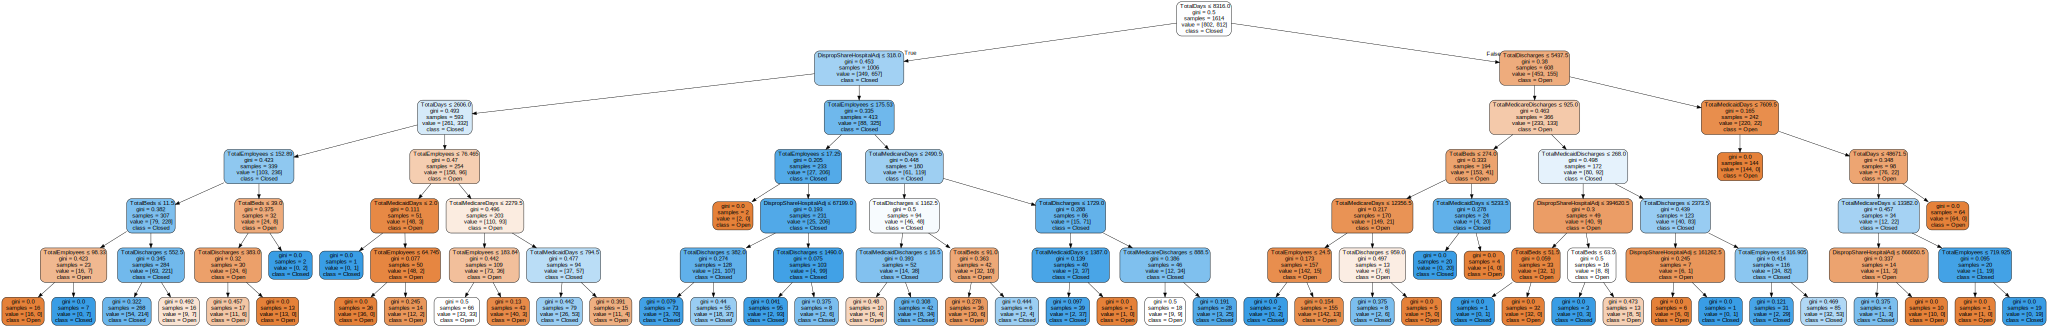

In [20]:
DTC_data = tree.export_graphviz(DTC, out_file=None, feature_names=X_train.columns, class_names=['Unclosed', 'Closed'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(DTC_data)
graph

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76       207
         1.0       0.74      0.83      0.78       197

    accuracy                           0.77       404
   macro avg       0.78      0.77      0.77       404
weighted avg       0.78      0.77      0.77       404



- Despite only including hospital (and not county) data, the model does pretty well! 81% accuracy
- Now, let's try including the county data in our analysis.

In [23]:
joined_data = pd.read_csv('../data/joined_data.csv')
joined_data

,HID,Year,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
0,H010001,2011,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8741694.0,0.0,2154.78,...,41766.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
1,H010001,2012,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8207980.0,0.0,2160.60,...,41828.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
2,H010001,2013,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,7940024.0,0.0,2271.00,...,40948.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
3,H010001,2014,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,2145563.0,0.0,2405.80,...,41077.0,104193.0,82477.0,3994.0,39543.0,0.0,0.0,7.0,15.0,4.0
4,H010001,2015,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,1720340.0,0.0,2379.50,...,41571.0,104173.0,82231.0,3713.0,43553.0,0.0,0.0,7.0,15.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75940,H713026,2022,BOGALUSA REHABILITATION HOSPITAL,621 S COLUMBIA STREET,BOGALUSA,LA,70427,0.0,0.0,33.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75941,H713027,2021,SAGE REHAB HOSPITAL OF LAFAYETTE,204 ENERGY PARKWAY SUITE B,LAFAYETTE,LA,70508,0.0,0.0,27.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75942,H713028,2021,ENCOMPASS HEALTH REHABILITATION HOSP,8650 MILLICENT WAY,SHREVEPORT,LA,71115,0.0,0.0,112.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75943,H713029,2022,SHREVEPORT REHABILITATION HOSPITAL,1451 FERN CIRCLE,SHREVEPORT,LA,71105,0.0,0.0,100.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Another issue with the first model (and why it might not be a great classifier) apart from not including county data is that there were some hospitals in there that weren't really rural. Let's first drop any hospitals with CdcRurality > 3.

In [24]:
joined_data[['FarP','RucaRural','RucaSuburban','RucaUrban','CdcRurality']].describe()

,FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
count,57895.000000,57895.000000,57895.000000,57895.000000,57895.000000
mean,13.751373,3.614336,7.635271,159.068054,310.590068
std,30.677431,4.332748,13.194249,357.895900,11831.799635
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,0.000000,2.000000
50%,0.000000,2.000000,4.000000,27.000000,3.000000
75%,0.335570,5.000000,8.000000,155.000000,5.000000
max,100.000000,33.000000,81.000000,2247.000000,456021.000000


In [25]:
joined_data = joined_data[joined_data['CdcRurality'] >= 3]
joined_data

,HID,Year,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
0,H010001,2011,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8741694.0,0.0,2154.78,...,41766.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
1,H010001,2012,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8207980.0,0.0,2160.60,...,41828.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
2,H010001,2013,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,7940024.0,0.0,2271.00,...,40948.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0
3,H010001,2014,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,2145563.0,0.0,2405.80,...,41077.0,104193.0,82477.0,3994.0,39543.0,0.0,0.0,7.0,15.0,4.0
4,H010001,2015,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,1720340.0,0.0,2379.50,...,41571.0,104173.0,82231.0,3713.0,43553.0,0.0,0.0,7.0,15.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75915,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,47.17,...,52027.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0
75916,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,55.38,...,52027.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0
75920,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,51.70,...,54987.0,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0
75921,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,59.35,...,54987.0,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0


- That actually eliminated more than half of our dataset! Now, let's add a count so we can get the average per year for each hospital.

In [26]:
joined_data['count'] = 1
joined_data

/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_28620/422584959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_data['count'] = 1


,HID,Year,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
0,H010001,2011,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8741694.0,0.0,2154.78,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
1,H010001,2012,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8207980.0,0.0,2160.60,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
2,H010001,2013,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,7940024.0,0.0,2271.00,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
3,H010001,2014,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,2145563.0,0.0,2405.80,...,104193.0,82477.0,3994.0,39543.0,0.0,0.0,7.0,15.0,4.0,1
4,H010001,2015,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,1720340.0,0.0,2379.50,...,104173.0,82231.0,3713.0,43553.0,0.0,0.0,7.0,15.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75915,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,47.17,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75916,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,55.38,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75920,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,51.70,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1
75921,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,59.35,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1


- Now sum all the data for each hospital:

In [27]:
sum_df = joined_data.groupby('HID').sum()
sum_df

,Year,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
HID,,,,,,,,,,,,,,,,,,,,,
H010001,20155,SOUTHEAST ALABAMA MEDICAL CENTER SOUTHE...,1108 ROSS CLARK CIRCLE 1108 R...,DOTHAN DOTHAN...,AL AL ...,36301 36301 ...,39729454.0,4728735.0,23258.23,3797.0,...,627372.0,498355.0,19495.0,268154.0,0.000000,0.0,70.0,150.0,40.0,10
H010005,20155,MARSHALL MEDICAL CENTER - SOUTH MARSHA...,2505 U.S. HIGHWAY 431 2505 U...,BOAZ BOAZ ...,AL AL ...,35957- 35957-...,12932548.0,0.0,10930.55,1941.0,...,572949.0,447075.0,12079.0,254804.0,0.000000,50.0,130.0,0.0,50.0,10
H010006,20155,ELIZA COFFEE MEMORIAL HOSPITAL ELIZA ...,205 MARENGO STREET 205 MA...,FLORENCE FLOREN...,AL AL ...,35630 35630 ...,14303974.0,2293939.0,9738.69,3185.0,...,555664.0,456209.0,14027.0,267311.0,0.000000,20.0,70.0,130.0,40.0,10
H010007,20155,MIZELL MEMORIAL HOSPITAL MIZELL...,702 MAIN STREET 702 MA...,OPP OPP ...,AL AL ...,36462- 36462-...,689079.0,0.0,1493.03,516.0,...,224334.0,180655.0,8209.0,235334.0,500.000000,130.0,10.0,0.0,60.0,10
H010008,22175,CRENSHAW COMMUNITY HOSPITAL CRENSH...,101 HOSPITAL CIRCLE CRENSH...,LUVERNE LUVERN...,AL AL ...,36049 36049 ...,806677.0,0.0,1034.25,319.0,...,0.0,0.0,0.0,0.0,253.846154,22.0,44.0,0.0,66.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H673067,6057,PAM REHAB HOSPITAL CORPUS CHRISTI PAM RE...,345 S. WATER STREET T ...,CORPUS CHRIST CORPUS...,TX TX ...,78401 78401 ...,0.0,0.0,330.03,120.0,...,724559.0,567063.0,19775.0,111349.0,0.000000,9.0,18.0,219.0,9.0,3
H673070,4039,SOUTH PLAINS REHABILITATION HOSPITAL SOUTH ...,5406 COLGATE STREET 5406 C...,LUBBOCK LUBBOC...,TX TX ...,79416 79416 ...,0.0,0.0,274.14,106.0,...,310569.0,245408.0,4255.0,55003.0,0.000000,2.0,14.0,120.0,6.0,2
H673073,4040,EVEREST REHABILITATION HOSPITAL LONG EVERES...,701 E LOOP 281 701 E ...,LONGVIEW LONGVI...,TX TX ...,75605 75605 ...,0.0,0.0,102.55,72.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,8.0,42.0,8.0,2


- And drop the non-numerical columns such as Address, along with the now-meaningless Year:

In [28]:
num_df = sum_df[sum_df.columns[sum_df.dtypes != 'object']]
num_df


,Year,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
HID,,,,,,,,,,,,,,,,,,,,,
H010001,20155,39729454.0,4728735.0,23258.23,3797.0,409540.0,134731.0,944085.0,75319.0,29367.0,...,627372.0,498355.0,19495.0,268154.0,0.000000,0.0,70.0,150.0,40.0,10
H010005,20155,12932548.0,0.0,10930.55,1941.0,161610.0,65102.0,359297.0,33083.0,14300.0,...,572949.0,447075.0,12079.0,254804.0,0.000000,50.0,130.0,0.0,50.0,10
H010006,20155,14303974.0,2293939.0,9738.69,3185.0,280959.0,89567.0,590692.0,52041.0,19031.0,...,555664.0,456209.0,14027.0,267311.0,0.000000,20.0,70.0,130.0,40.0,10
H010007,20155,689079.0,0.0,1493.03,516.0,35173.0,5163.0,51875.0,7303.0,1636.0,...,224334.0,180655.0,8209.0,235334.0,500.000000,130.0,10.0,0.0,60.0,10
H010008,22175,806677.0,0.0,1034.25,319.0,9999.0,2859.0,19448.0,2241.0,879.0,...,0.0,0.0,0.0,0.0,253.846154,22.0,44.0,0.0,66.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H673067,6057,0.0,0.0,330.03,120.0,23327.0,0.0,33148.0,1790.0,0.0,...,724559.0,567063.0,19775.0,111349.0,0.000000,9.0,18.0,219.0,9.0,3
H673070,4039,0.0,0.0,274.14,106.0,19098.0,0.0,30834.0,1554.0,0.0,...,310569.0,245408.0,4255.0,55003.0,0.000000,2.0,14.0,120.0,6.0,2
H673073,4040,0.0,0.0,102.55,72.0,5379.0,0.0,6763.0,457.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,8.0,42.0,8.0,2


In [29]:
num_df.drop(columns=['Year'], inplace=True)

/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_28620/3498267170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(columns=['Year'], inplace=True)


-Now, we can get an average for each hospital over the time period:

In [30]:
means_df = num_df.div(num_df['count'], axis=0)
means_df

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
HID,,,,,,,,,,,,,,,,,,,,,
H010001,3.972945e+06,472873.5,2325.823000,379.7,40954.000000,13473.100000,94408.500000,7531.900000,2936.700000,18929.300000,...,62737.200000,49835.5,1949.500000,26815.400000,0.000000,0.0,7.0,15.0,4.0,1.0
H010005,1.293255e+06,0.0,1093.055000,194.1,16161.000000,6510.200000,35929.700000,3308.300000,1430.000000,8387.400000,...,57294.900000,44707.5,1207.900000,25480.400000,0.000000,5.0,13.0,0.0,5.0,1.0
H010006,1.430397e+06,229393.9,973.869000,318.5,28095.900000,8956.700000,59069.200000,5204.100000,1903.100000,12142.200000,...,55566.400000,45620.9,1402.700000,26731.100000,0.000000,2.0,7.0,13.0,4.0,1.0
H010007,6.890790e+04,0.0,149.303000,51.6,3517.300000,516.300000,5187.500000,730.300000,163.600000,1270.400000,...,22433.400000,18065.5,820.900000,23533.400000,50.000000,13.0,1.0,0.0,6.0,1.0
H010008,7.333427e+04,0.0,94.022727,29.0,909.000000,259.909091,1768.000000,203.727273,79.909091,408.363636,...,0.000000,0.0,0.000000,0.000000,23.076923,2.0,4.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H673067,0.000000e+00,0.0,110.010000,40.0,7775.666667,0.000000,11049.333333,596.666667,0.000000,796.333333,...,241519.666667,189021.0,6591.666667,37116.333333,0.000000,3.0,6.0,73.0,3.0,1.0
H673070,0.000000e+00,0.0,137.070000,53.0,9549.000000,0.000000,15417.000000,777.000000,0.000000,1208.000000,...,155284.500000,122704.0,2127.500000,27501.500000,0.000000,1.0,7.0,60.0,3.0,1.0
H673073,0.000000e+00,0.0,51.275000,36.0,2689.500000,0.000000,3381.500000,228.500000,0.000000,278.500000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,4.0,21.0,4.0,1.0


- And now, finally, we can take our samples of closed and unclosed hospitals:

In [31]:
closed_df = means_df[means_df['HasClosed'] > 0]
closed_df

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
HID,,,,,,,,,,,,,,,,,,,,,
H010015,9.767000e+03,0.0,75.030000,27.000000,295.000000,0.000000,592.000000,92.000000,30.000000,204.000000,...,0.000000,0.000000,0.000,0.000000,87.500000,8.0,1.0,0.0,6.0,1.0
H010027,3.065600e+04,0.0,124.500000,20.000000,243.500000,95.000000,439.000000,69.000000,40.000000,146.500000,...,0.000000,0.000000,0.000,0.000000,14.285714,8.0,6.0,0.0,5.0,1.0
H010047,5.457600e+04,0.0,44.640000,22.000000,1070.500000,194.500000,1581.250000,326.250000,75.250000,522.250000,...,36953.625000,29288.125000,1308.250,31988.875000,0.000000,2.0,11.0,1.0,5.0,1.0
H010066,3.538200e+04,0.0,34.070000,22.000000,330.500000,46.500000,498.500000,89.000000,21.000000,167.000000,...,0.000000,0.000000,0.000,0.000000,50.000000,13.0,1.0,0.0,6.0,1.0
H030055,1.006777e+06,1564629.4,1531.018000,197.700000,14968.300000,8681.700000,39870.700000,2779.200000,1747.900000,8250.000000,...,124227.800000,104962.700000,4089.500,25955.500000,26.315789,8.0,23.0,12.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H451357,0.000000e+00,0.0,228.565000,24.000000,1234.750000,13.625000,1640.750000,180.375000,2.500000,315.375000,...,15478.000000,12128.250000,288.875,28513.000000,0.000000,5.0,2.0,0.0,6.0,1.0
H491306,0.000000e+00,0.0,119.152857,25.000000,2560.714286,20.285714,3245.714286,240.000000,7.857143,365.857143,...,0.000000,0.000000,0.000,0.000000,0.000000,4.0,0.0,0.0,6.0,1.0
H510071,1.069912e+06,1195124.2,430.428000,95.900000,7582.400000,2123.600000,15561.200000,1693.300000,768.700000,3803.400000,...,36105.900000,29493.500000,952.900,22460.400000,0.000000,3.0,13.0,0.0,5.0,1.0


In [32]:
not_closed_df = means_df[means_df['HasClosed'] == 0].sample(n=closed_df.shape[0], random_state=1)
not_closed_df

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
HID,,,,,,,,,,,,,,,,,,,,,
H010035,787574.5,0.0,750.523,124.6,12432.3,3421.9,25720.8,2964.1,1448.9,7330.8,...,49573.0,39832.3,1103.3,25609.6,0.0,14.0,4.0,0.0,5.0,1.0
H424011,0.0,0.0,305.629,121.5,743.4,2213.6,40348.9,24.2,65.9,418.3,...,246009.3,199112.0,8474.9,30975.7,0.0,1.0,5.0,83.0,3.0,1.0
H390044,3778943.5,6124488.9,4600.008,533.1,46036.4,5905.8,134997.4,8803.6,1253.2,29086.2,...,250294.4,200608.9,8380.8,36279.7,0.0,0.0,22.0,68.0,3.0,1.0
H161333,0.0,0.0,143.162,17.0,1924.2,27.1,2755.9,83.2,10.1,162.2,...,57990.8,49536.6,1452.5,32831.7,0.0,0.0,6.0,14.0,4.0,1.0
H170103,99175.2,0.0,521.855,77.4,5505.8,451.0,10780.4,1121.3,39.6,2443.1,...,20798.9,16128.4,332.6,34290.5,0.0,0.0,6.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H390009,2268232.2,2389247.5,1758.003,308.1,18793.4,3610.7,62313.3,3970.2,650.2,13279.7,...,164902.5,133448.5,4629.8,29234.9,0.0,3.0,17.0,52.0,3.0,1.0
H341320,0.0,0.0,106.939,25.0,1362.3,75.7,1997.9,287.0,32.2,432.6,...,0.0,0.0,0.0,0.0,12.5,3.0,0.0,0.0,6.0,1.0
H261329,0.0,0.0,222.521,22.9,906.2,631.2,2949.7,164.2,195.8,719.0,...,21456.6,17155.5,395.5,25021.4,0.0,6.0,1.0,0.0,6.0,1.0


- Merge them:

In [33]:
joined_df = pd.concat([closed_df, not_closed_df]).drop(columns=['count', 'ClosureYear', 'Converted', '# of Beds'])
joined_df

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
HID,,,,,,,,,,,,,,,,,,,,,
H010015,9767.0,0.0,75.030,27.0,295.0,0.0,592.00,92.00,30.00,204.00,...,29668.000,0.000,0.000,0.00,0.000,87.500000,8.0,1.0,0.0,6.0
H010027,30656.0,0.0,124.500,20.0,243.5,95.0,439.00,69.00,40.00,146.50,...,43345.500,0.000,0.000,0.00,0.000,14.285714,8.0,6.0,0.0,5.0
H010047,54576.0,0.0,44.640,22.0,1070.5,194.5,1581.25,326.25,75.25,522.25,...,45201.875,36953.625,29288.125,1308.25,31988.875,0.000000,2.0,11.0,1.0,5.0
H010066,35382.0,0.0,34.070,22.0,330.5,46.5,498.50,89.00,21.00,167.00,...,34432.500,0.000,0.000,0.00,0.000,50.000000,13.0,1.0,0.0,6.0
H030055,1006777.0,1564629.4,1531.018,197.7,14968.3,8681.7,39870.70,2779.20,1747.90,8250.00,...,41406.200,124227.800,104962.700,4089.50,25955.500,26.315789,8.0,23.0,12.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H390009,2268232.2,2389247.5,1758.003,308.1,18793.4,3610.7,62313.30,3970.20,650.20,13279.70,...,47602.200,164902.500,133448.500,4629.80,29234.900,0.000000,3.0,17.0,52.0,3.0
H341320,0.0,0.0,106.939,25.0,1362.3,75.7,1997.90,287.00,32.20,432.60,...,36222.600,0.000,0.000,0.00,0.000,12.500000,3.0,0.0,0.0,6.0
H261329,0.0,0.0,222.521,22.9,906.2,631.2,2949.70,164.20,195.80,719.00,...,40319.000,21456.600,17155.500,395.50,25021.400,0.000000,6.0,1.0,0.0,6.0


In [34]:
joined_df.describe()

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
count,2.520000e+02,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,4.331214e+05,3.748884e+05,420.210304,97.347385,5427.092865,1504.404745,14490.055421,1008.231340,321.932838,2730.853369,...,44840.624568,51479.788581,40975.396787,1486.229572,18216.434641,17.568031,4.166667,4.757937,14.404762,4.813492
std,1.175735e+06,2.701108e+06,761.739877,345.947276,9351.371582,3811.206917,28294.630004,1818.385563,729.760278,5689.733879,...,8839.044522,85361.104714,67021.591219,2668.927833,14621.086354,32.144392,3.638550,5.472217,31.370725,1.147028
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25256.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000e+00,0.000000e+00,79.916500,25.000000,985.750000,35.333333,1657.250000,133.125000,10.132143,259.958333,...,38697.183333,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000
50%,6.494864e+03,0.000000e+00,133.959500,36.500000,1873.650000,194.400000,3573.222222,301.416667,43.900000,635.442857,...,44603.500000,17511.300000,14172.659091,484.663636,23621.887500,0.000000,3.500000,4.000000,0.000000,5.000000
75%,2.019325e+05,0.000000e+00,370.373286,82.250000,4332.220833,908.958333,10558.700000,743.765909,223.937500,1507.895455,...,50865.750000,51301.875000,42653.022727,1457.775000,30340.000000,16.911765,6.000000,6.000000,14.250000,6.000000
max,8.297088e+06,4.053909e+07,5158.890000,5310.200000,51035.000000,34177.700000,174569.100000,9615.181818,5785.800000,37687.600000,...,76943.000000,488750.625000,363355.750000,21476.750000,51766.000000,100.000000,18.000000,35.000000,169.000000,6.000000


- Here are our feature variables:

In [35]:
joined_df.columns

Index(['DispropShareHospitalAdj', 'IndirectMedicalEducationAdj',
       'TotalEmployees', 'TotalBeds', 'TotalMedicareDays', 'TotalMedicaidDays',
       'TotalDays', 'TotalMedicareDischarges', 'TotalMedicaidDischarges',
       'TotalDischarges', 'HasClosed', 'HasEmergencyServices',
       'HasBirthingFriendlyDesignation', 'GEOID', 'Inflow_Household',
       'Inflow_Individual', 'Inflow_AGI', 'Outflow_Household',
       'Outflow_Individual', 'Outflow_AGI', 'Total Population (ACS1)',
       'Labor Force (ACS1)', 'Unemployed (ACS1)', 'Median Income (ACS1)',
       'Total Population (ACS5)', 'Labor Force (ACS5)', 'Unemployed (ACS5)',
       'Median Income (ACS5)', 'Total Population (ACSSE)',
       'Labor Force (ACSSE)', 'Unemployed (ACSSE)', 'Median Income (ACSSE)',
       'FarP', 'RucaRural', 'RucaSuburban', 'RucaUrban', 'CdcRurality'],
      dtype='object')

- Let's try visualizing some of our data:

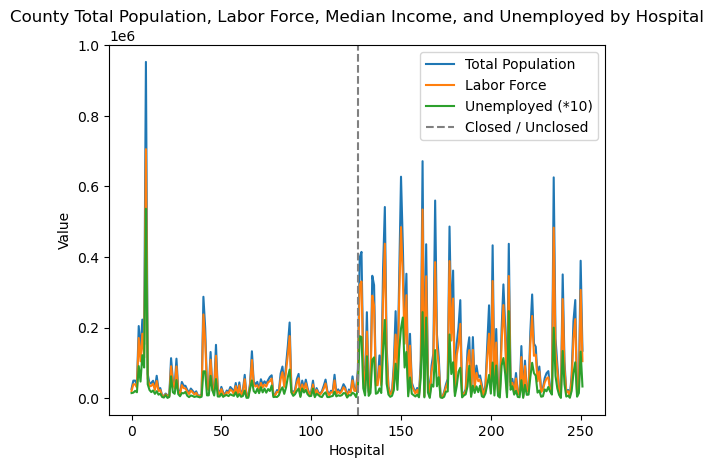

In [36]:
plt.plot(joined_df['Total Population (ACS5)'].values)
plt.plot(joined_df['Labor Force (ACS5)'].values)
plt.plot(joined_df['Unemployed (ACS5)'].values*10)
plt.title('County Total Population, Labor Force, Median Income, and Unemployed by Hospital')
plt.xlabel('Hospital')
plt.ylabel('Value')
plt.axvline(x=len(closed_df), color='gray', linestyle='--')
plt.legend(['Total Population', 'Labor Force', 'Unemployed (*10)', 'Closed / Unclosed'])

- It seems clear that hospitals in smaller counties are more likely to close.

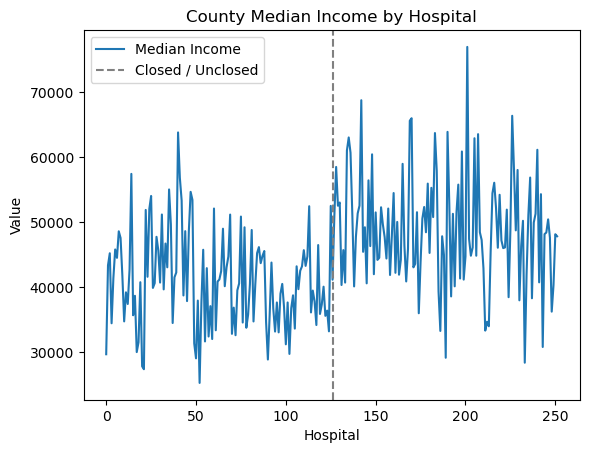

In [37]:
plt.plot(joined_df['Median Income (ACS5)'].values)
plt.title('County Median Income by Hospital')
plt.xlabel('Hospital')
plt.ylabel('Value')
plt.axvline(x=len(closed_df), color='gray', linestyle='--')
plt.legend(['Median Income', 'Closed / Unclosed'])

- However, there does not appear to be a relationship to median income.

Text(0, 0.5, 'Days')

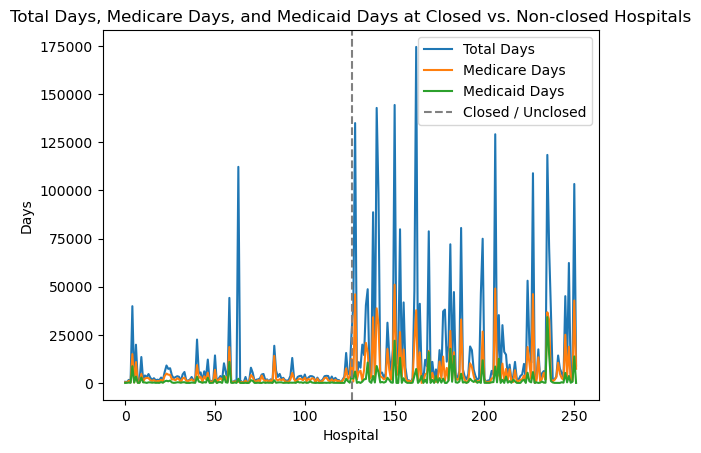

In [38]:
plt.plot(joined_df['TotalDays'].values)
plt.plot(joined_df['TotalMedicareDays'].values)
plt.plot(joined_df['TotalMedicaidDays'].values)
plt.axvline(x=len(closed_df), color='gray', linestyle='--')
plt.title('Total Days, Medicare Days, and Medicaid Days at Closed vs. Non-closed Hospitals')
plt.legend(['Total Days', 'Medicare Days', 'Medicaid Days', 'Closed / Unclosed'])
plt.xlabel('Hospital')
plt.ylabel('Days')

- It seems smaller hospitals (with less patient time spent) are more likely to close. Let's check other measures.

In [39]:
joined_df = joined_df.replace([np.inf, -np.inf], np.nan)
#still get a use_inf_as_na warning in cells below, despite the above line; this hides it
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

Text(0.5, 1.0, 'Total Employees of Closed vs. Non-closed Hospitals')

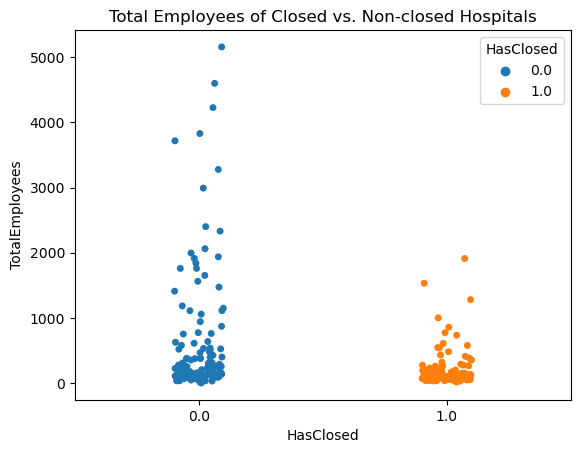

In [40]:
sns.stripplot(x='HasClosed', y='TotalEmployees', data=joined_df, hue='HasClosed')
plt.title('Total Employees of Closed vs. Non-closed Hospitals')

Text(0.5, 1.0, 'Total Beds of Closed vs. Non-closed Hospitals')

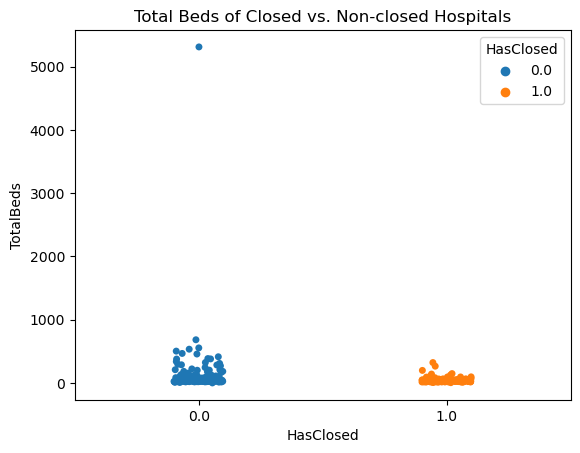

In [41]:
sns.stripplot(x='HasClosed', y='TotalBeds', data=joined_df, hue='HasClosed')
plt.title('Total Beds of Closed vs. Non-closed Hospitals')

Text(0.5, 1.0, 'Total Days vs. Total Beds at Closed vs. Unclosed Hospitals')

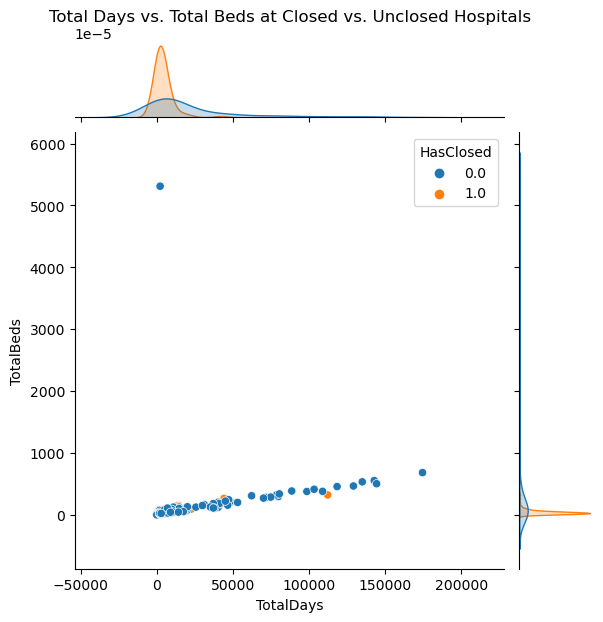

In [42]:
sns.jointplot(x='TotalDays', y='TotalBeds', data=joined_df, hue='HasClosed')
plt.title('Total Days vs. Total Beds at Closed vs. Unclosed Hospitals', fontsize=12, pad=80)

Text(0.5, 1.0, 'Total Employees vs. Medicare Adjustment in Closed/Unclosed Hospitals')

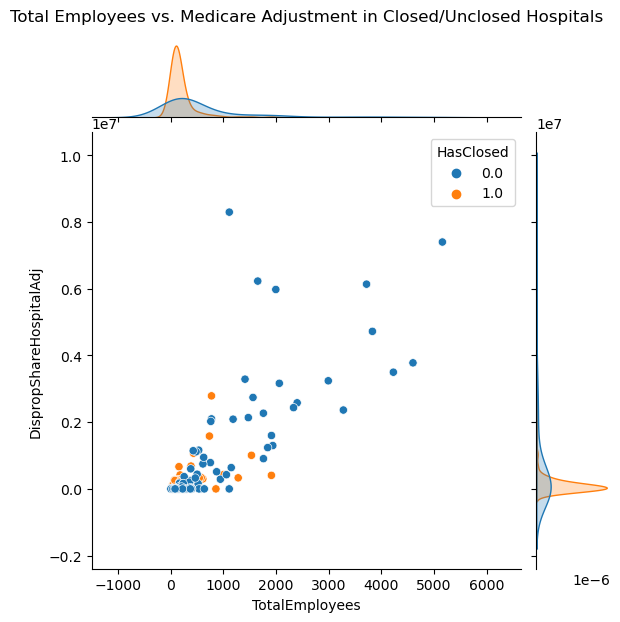

In [43]:
sns.jointplot(x='TotalEmployees', y='DispropShareHospitalAdj', data=joined_df, hue='HasClosed')
plt.title('Total Employees vs. Medicare Adjustment in Closed/Unclosed Hospitals', fontsize=12, pad=80)

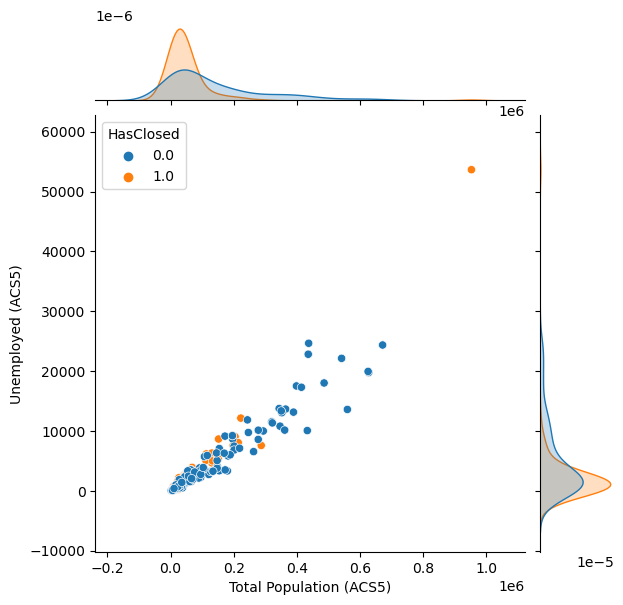

In [44]:
sns.jointplot(x='Total Population (ACS5)', y='Unemployed (ACS5)', data=joined_df, hue='HasClosed')
plt.title('Total Population vs. Unemployed in Closed/Unclosed Hospitals', fontsize=12, pad=80)

- It appears that in fact the graphs were misleading: in all these cases, outliers caused the apparent difference. Back to the drawing board! Let's try some more machine learning to tease out the differences.

In [45]:
joined_df.describe()

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
count,2.520000e+02,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,4.331214e+05,3.748884e+05,420.210304,97.347385,5427.092865,1504.404745,14490.055421,1008.231340,321.932838,2730.853369,...,44840.624568,51479.788581,40975.396787,1486.229572,18216.434641,17.568031,4.166667,4.757937,14.404762,4.813492
std,1.175735e+06,2.701108e+06,761.739877,345.947276,9351.371582,3811.206917,28294.630004,1818.385563,729.760278,5689.733879,...,8839.044522,85361.104714,67021.591219,2668.927833,14621.086354,32.144392,3.638550,5.472217,31.370725,1.147028
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25256.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000e+00,0.000000e+00,79.916500,25.000000,985.750000,35.333333,1657.250000,133.125000,10.132143,259.958333,...,38697.183333,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000
50%,6.494864e+03,0.000000e+00,133.959500,36.500000,1873.650000,194.400000,3573.222222,301.416667,43.900000,635.442857,...,44603.500000,17511.300000,14172.659091,484.663636,23621.887500,0.000000,3.500000,4.000000,0.000000,5.000000
75%,2.019325e+05,0.000000e+00,370.373286,82.250000,4332.220833,908.958333,10558.700000,743.765909,223.937500,1507.895455,...,50865.750000,51301.875000,42653.022727,1457.775000,30340.000000,16.911765,6.000000,6.000000,14.250000,6.000000
max,8.297088e+06,4.053909e+07,5158.890000,5310.200000,51035.000000,34177.700000,174569.100000,9615.181818,5785.800000,37687.600000,...,76943.000000,488750.625000,363355.750000,21476.750000,51766.000000,100.000000,18.000000,35.000000,169.000000,6.000000


- Caught an outlier:

In [46]:
joined_df[joined_df['TotalBeds'] < 0.5]

,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,TotalMedicaidDischarges,TotalDischarges,...,Median Income (ACS5),Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
HID,,,,,,,,,,,,,,,,,,,,,
H370239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48725.0,0.0,0.0,0.0,0.0,100.0,2.0,2.0,0.0,5.0


In [47]:
joined_df.drop(index=joined_df[joined_df['TotalBeds'] < 0.5].index, inplace=True)

In [81]:
target = joined_df['HasClosed']
features = joined_df.drop(columns=['HasClosed'])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((200, 36), (51, 36))

In [83]:
DTC = DecisionTreeClassifier(random_state=42, max_depth=6)
DTC.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

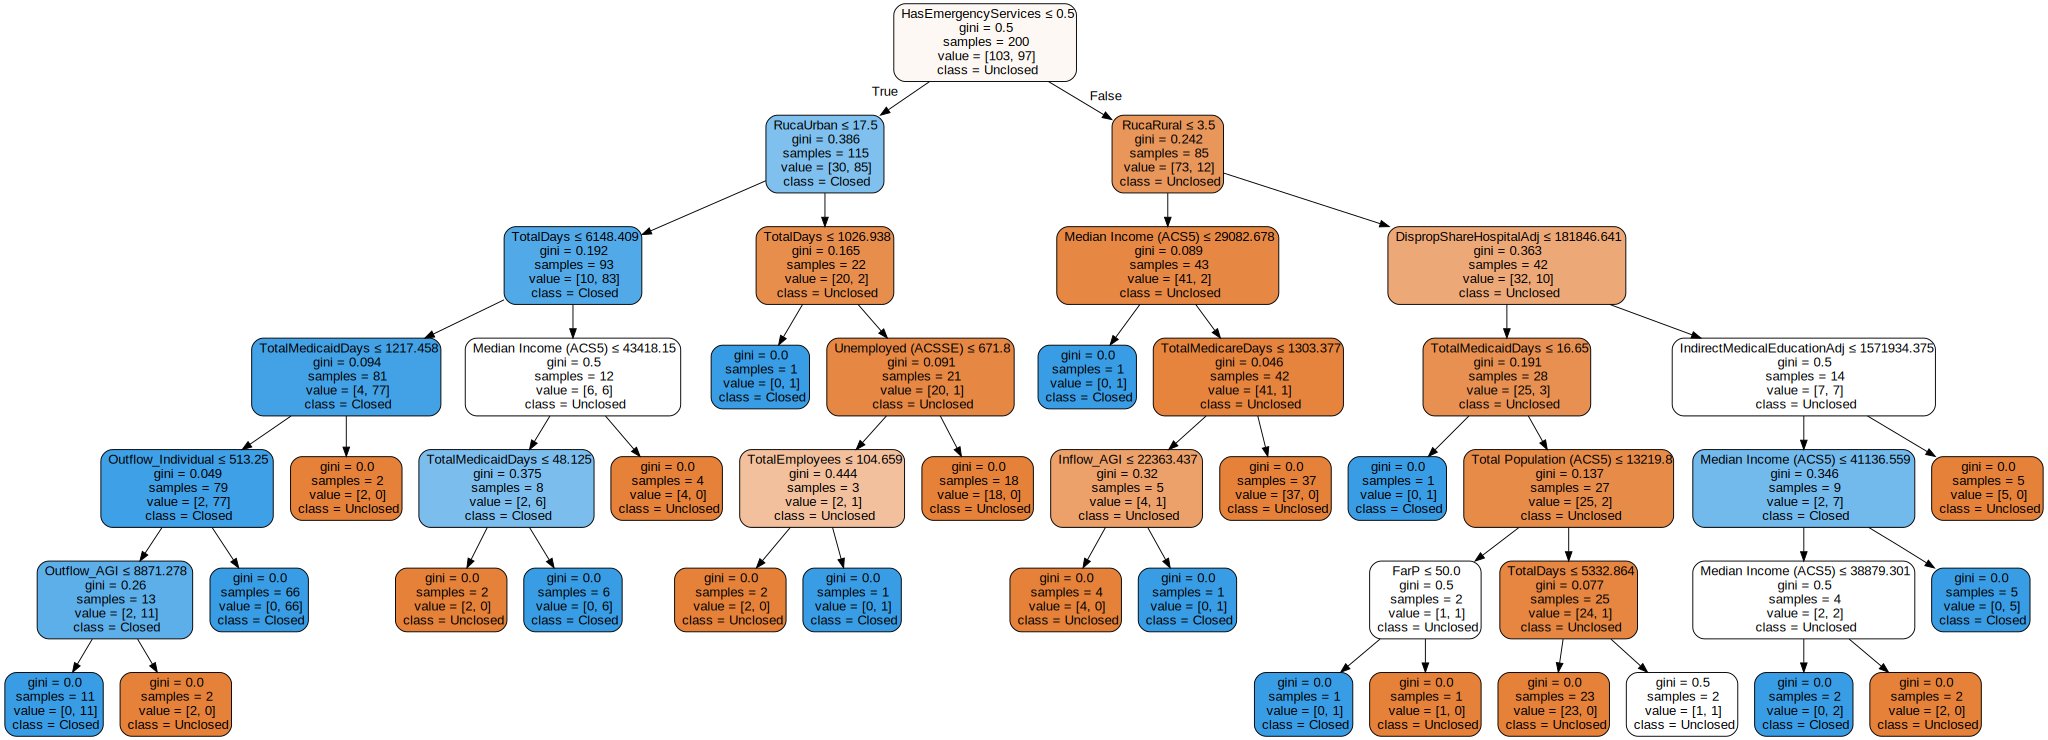

In [84]:
DTC_data = tree.export_graphviz(DTC, out_file=None, feature_names=X_train.columns, class_names=['Unclosed', 'Closed'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(DTC_data)
graph

In [89]:
DTC.score(X_test, y_test)

0.8823529411764706

In [90]:
print(classification_report(y_test, DTC.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        22
         1.0       0.93      0.86      0.89        29

    accuracy                           0.88        51
   macro avg       0.88      0.89      0.88        51
weighted avg       0.89      0.88      0.88        51



In [91]:
perm = PermutationImportance(DTC, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2039 ± 0.0314,HasEmergencyServices
0.1333 ± 0.0576,TotalDays
0.1059 ± 0.0637,TotalMedicaidDays
0.1059 ± 0.0532,RucaUrban
0.0627 ± 0.0457,Outflow_AGI
0.0549 ± 0.0157,RucaRural
0.0549 ± 0.0384,TotalMedicareDays
0.0431 ± 0.0457,Median Income (ACS5)
0.0275 ± 0.0192,Outflow_Individual
0.0196 ± 0.0248,Inflow_AGI


In [87]:
joined_df[joined_df['HasEmergencyServices'] <= 0.5]['HasClosed'].value_counts()

HasClosed
1.0    111
0.0     37
Name: count, dtype: int64

In [88]:
joined_df[joined_df['HasEmergencyServices'] > 0.5]['HasClosed'].value_counts()

HasClosed
0.0    88
1.0    15
Name: count, dtype: int64

- This decision tree predicts really well, using a combination of hospital features and rurality.
- Finally, let's see if we can take time into account by using the tsfresh library to extract time-based features. Let's go back to the data before merging:

In [53]:
joined_data

,HID,Year,Name,Address,City,State,Zip,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
0,H010001,2011,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8741694.0,0.0,2154.78,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
1,H010001,2012,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,8207980.0,0.0,2160.60,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
2,H010001,2013,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,7940024.0,0.0,2271.00,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
3,H010001,2014,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,2145563.0,0.0,2405.80,...,104193.0,82477.0,3994.0,39543.0,0.0,0.0,7.0,15.0,4.0,1
4,H010001,2015,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,1720340.0,0.0,2379.50,...,104173.0,82231.0,3713.0,43553.0,0.0,0.0,7.0,15.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75915,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,47.17,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75916,H673073,2020,EVEREST REHABILITATION HOSPITAL LONG,701 E LOOP 281,LONGVIEW,TX,75605,0.0,0.0,55.38,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75920,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,51.70,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1
75921,H673074,2020,EVEREST REHABILITATION HOSPITAL TEMP,23621 SE HK DODGEN LOOP,TEMPLE,TX,76504,0.0,0.0,59.35,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1


In [54]:
num_data = joined_data[pd.Index(['HID']).append(joined_data.columns[joined_data.dtypes != 'object'])]
num_data

,HID,Year,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,...,Total Population (ACSSE),Labor Force (ACSSE),Unemployed (ACSSE),Median Income (ACSSE),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality,count
0,H010001,2011,8741694.0,0.0,2154.78,408.0,42292.0,16707.0,90432.0,7536.0,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
1,H010001,2012,8207980.0,0.0,2160.60,408.0,42542.0,15091.0,86240.0,7586.0,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
2,H010001,2013,7940024.0,0.0,2271.00,408.0,46308.0,15850.0,94243.0,7954.0,...,NaN,NaN,NaN,NaN,0.0,0.0,7.0,15.0,4.0,1
3,H010001,2014,2145563.0,0.0,2405.80,398.0,46163.0,16111.0,94934.0,8462.0,...,104193.0,82477.0,3994.0,39543.0,0.0,0.0,7.0,15.0,4.0,1
4,H010001,2015,1720340.0,0.0,2379.50,400.0,43444.0,9014.0,89693.0,8326.0,...,104173.0,82231.0,3713.0,43553.0,0.0,0.0,7.0,15.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75915,H673073,2020,0.0,0.0,47.17,36.0,557.0,NaN,714.0,51.0,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75916,H673073,2020,0.0,0.0,55.38,36.0,4822.0,NaN,6049.0,406.0,...,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,4.0,1
75920,H673074,2020,0.0,0.0,51.70,36.0,306.0,NaN,474.0,34.0,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1
75921,H673074,2020,0.0,0.0,59.35,36.0,3822.0,NaN,5265.0,321.0,...,NaN,NaN,NaN,NaN,0.0,3.0,5.0,57.0,3.0,1


In [55]:
num_data.isna().sum()/num_data.shape[0]

HID                               0.000000
Year                              0.000000
DispropShareHospitalAdj           0.000000
IndirectMedicalEducationAdj       0.000000
TotalEmployees                    0.013887
TotalBeds                         0.007970
TotalMedicareDays                 0.013092
TotalMedicaidDays                 0.120323
TotalDays                         0.008984
TotalMedicareDischarges           0.013065
TotalMedicaidDischarges           0.127308
TotalDischarges                   0.009285
# of Beds                         0.977458
ClosureYear                       0.977458
Converted                         0.977458
HasClosed                         0.000000
HasEmergencyServices              0.155026
HasBirthingFriendlyDesignation    0.155026
GEOID                             0.000000
Inflow_Household                  0.000000
Inflow_Individual                 0.000000
Inflow_AGI                        0.000000
Outflow_Household                 0.000000
Outflow_Ind

- tsfresh cannot work with na values so drop columns with >25% NA and fill remaining NA values with the column means

In [57]:
final_data = num_data.drop(columns=['GEOID', 'count'])
final_data = final_data.drop(columns=final_data.columns[final_data.isna().sum() > 0.25 * final_data.shape[0]])
z = final_data.select_dtypes(include=['float64', 'int64']).columns
final_data[z] = final_data[z].fillna(final_data[z].mean())
final_data

,HID,Year,DispropShareHospitalAdj,IndirectMedicalEducationAdj,TotalEmployees,TotalBeds,TotalMedicareDays,TotalMedicaidDays,TotalDays,TotalMedicareDischarges,...,Outflow_AGI,Total Population (ACS5),Labor Force (ACS5),Unemployed (ACS5),Median Income (ACS5),FarP,RucaRural,RucaSuburban,RucaUrban,CdcRurality
0,H010001,2011,8741694.0,0.0,2154.78,408.0,42292.0,16707.000000,90432.0,7536.0,...,107343.0,100310.0,78488.0,3528.0,41766.0,0.0,0.0,7.0,15.0,4.0
1,H010001,2012,8207980.0,0.0,2160.60,408.0,42542.0,15091.000000,86240.0,7586.0,...,107242.0,101459.0,79477.0,3732.0,41828.0,0.0,0.0,7.0,15.0,4.0
2,H010001,2013,7940024.0,0.0,2271.00,408.0,46308.0,15850.000000,94243.0,7954.0,...,101600.0,102326.0,80377.0,3957.0,40948.0,0.0,0.0,7.0,15.0,4.0
3,H010001,2014,2145563.0,0.0,2405.80,398.0,46163.0,16111.000000,94934.0,8462.0,...,70944.0,103079.0,81209.0,3901.0,41077.0,0.0,0.0,7.0,15.0,4.0
4,H010001,2015,1720340.0,0.0,2379.50,400.0,43444.0,9014.000000,89693.0,8326.0,...,108272.0,103534.0,81625.0,3983.0,41571.0,0.0,0.0,7.0,15.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75915,H673073,2020,0.0,0.0,47.17,36.0,557.0,2489.360494,714.0,51.0,...,198272.0,123633.0,95205.0,2363.0,52027.0,0.0,0.0,4.0,21.0,4.0
75916,H673073,2020,0.0,0.0,55.38,36.0,4822.0,2489.360494,6049.0,406.0,...,198272.0,123633.0,95205.0,2363.0,52027.0,0.0,0.0,4.0,21.0,4.0
75920,H673074,2020,0.0,0.0,51.70,36.0,306.0,2489.360494,474.0,34.0,...,751162.0,355700.0,267137.0,11741.0,54987.0,0.0,3.0,5.0,57.0,3.0
75921,H673074,2020,0.0,0.0,59.35,36.0,3822.0,2489.360494,5265.0,321.0,...,751162.0,355700.0,267137.0,11741.0,54987.0,0.0,3.0,5.0,57.0,3.0


In [58]:
final_data.columns

Index(['HID', 'Year', 'DispropShareHospitalAdj', 'IndirectMedicalEducationAdj',
       'TotalEmployees', 'TotalBeds', 'TotalMedicareDays', 'TotalMedicaidDays',
       'TotalDays', 'TotalMedicareDischarges', 'TotalMedicaidDischarges',
       'TotalDischarges', 'HasClosed', 'HasEmergencyServices',
       'HasBirthingFriendlyDesignation', 'Inflow_Household',
       'Inflow_Individual', 'Inflow_AGI', 'Outflow_Household',
       'Outflow_Individual', 'Outflow_AGI', 'Total Population (ACS5)',
       'Labor Force (ACS5)', 'Unemployed (ACS5)', 'Median Income (ACS5)',
       'FarP', 'RucaRural', 'RucaSuburban', 'RucaUrban', 'CdcRurality'],
      dtype='object')

In [59]:
target = final_data[['HID', 'HasClosed']]
features = final_data.drop(columns=['HasClosed'])

In [60]:
fc_parameters = {
                 'abs_energy':None, # Returns the absolute energy of the time series which is the sum over the squared values
                 'absolute_sum_of_changes':None, # Returns the sum over the absolute value of consecutive changes in the series x
                 'fft_aggregated':[ {'aggtype': 'centroid'}, # Returns the spectral centroid (mean), 
                                    {'aggtype': 'variance'}, # variance, 
                                    {'aggtype': 'skew'},     # skew, 
                                    {'aggtype': 'kurtosis'}], # and kurtosis of the absolute fourier transform spectrum.
                 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], # Uses c3 statistics to measure non linearity in the time series
                 'standard_deviation': None, # Returns the standard deviation of x
                 'variance': None, # Returns the variance of x
                 'skewness': None, # Returns the sample skewness of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G1).
                 'kurtosis': None, # Returns the kurtosis of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G2).
                 'maximum': None, # Calculates the highest value of the time series x.
                 'minimum': None, # Calculates the lowest value of the time series x.
                 'sample_entropy':None, # Calculate and return sample entropy of x.
                 'mean_abs_change':None, # Average over first differences.
                 'sum_values':None, # Calculates the sum over the time series values
                }

In [61]:
X = extract_features(features,
                     column_id='HID',
                     column_sort='Year',
                     default_fc_parameters=fc_parameters, 
                     impute_function=impute)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/dan/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
Feature Extraction: 100%|██████████| 10/10 [06:27<00:00, 38.73s/it]


In [62]:
X

,DispropShareHospitalAdj__abs_energy,DispropShareHospitalAdj__absolute_sum_of_changes,"DispropShareHospitalAdj__fft_aggregated__aggtype_""centroid""","DispropShareHospitalAdj__fft_aggregated__aggtype_""variance""","DispropShareHospitalAdj__fft_aggregated__aggtype_""skew""","DispropShareHospitalAdj__fft_aggregated__aggtype_""kurtosis""",DispropShareHospitalAdj__c3__lag_1,DispropShareHospitalAdj__c3__lag_2,DispropShareHospitalAdj__c3__lag_3,DispropShareHospitalAdj__standard_deviation,...,CdcRurality__c3__lag_3,CdcRurality__standard_deviation,CdcRurality__variance,CdcRurality__skewness,CdcRurality__kurtosis,CdcRurality__maximum,CdcRurality__minimum,CdcRurality__sample_entropy,CdcRurality__mean_abs_change,CdcRurality__sum_values
H010001,2.385564e+14,8428740.0,1.153811,2.468725,1.345587,3.944027,9.838117e+19,3.651748e+19,3.082493e+19,2.841011e+06,...,64.0,0.0,0.0,0.0,0.0,4.0,4.0,0.251314,0.0,40.0
H010005,2.615313e+13,3645025.0,1.125669,2.235020,1.348792,4.115907,3.753312e+18,1.561150e+18,1.040344e+18,9.709815e+05,...,125.0,0.0,0.0,0.0,0.0,5.0,5.0,0.251314,0.0,50.0
H010006,3.341583e+13,4967232.0,1.183888,2.153978,1.148748,3.874759,3.446561e+18,1.496351e+18,1.939508e+18,1.138221e+06,...,64.0,0.0,0.0,0.0,0.0,4.0,4.0,0.251314,0.0,40.0
H010007,8.645031e+10,201959.0,1.156086,1.937172,1.172568,4.071325,5.198656e+14,1.688338e+14,1.101592e+14,6.242381e+04,...,216.0,0.0,0.0,0.0,0.0,6.0,6.0,0.251314,0.0,60.0
H010008,1.602585e+11,310572.0,1.358236,1.925478,0.838308,4.452869,1.130985e+15,1.645210e+14,7.670897e+13,9.586992e+04,...,216.0,0.0,0.0,0.0,0.0,6.0,6.0,0.223144,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H673067,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.098612,0.0,9.0
H673070,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,6.0
H673073,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.251314,0.0,8.0
H673074,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,6.0


In [63]:
for col in X.columns:
    print(col)

DispropShareHospitalAdj__abs_energy
DispropShareHospitalAdj__absolute_sum_of_changes
DispropShareHospitalAdj__fft_aggregated__aggtype_"centroid"
DispropShareHospitalAdj__fft_aggregated__aggtype_"variance"
DispropShareHospitalAdj__fft_aggregated__aggtype_"skew"
DispropShareHospitalAdj__fft_aggregated__aggtype_"kurtosis"
DispropShareHospitalAdj__c3__lag_1
DispropShareHospitalAdj__c3__lag_2
DispropShareHospitalAdj__c3__lag_3
DispropShareHospitalAdj__standard_deviation
DispropShareHospitalAdj__variance
DispropShareHospitalAdj__skewness
DispropShareHospitalAdj__kurtosis
DispropShareHospitalAdj__maximum
DispropShareHospitalAdj__minimum
DispropShareHospitalAdj__sample_entropy
DispropShareHospitalAdj__mean_abs_change
DispropShareHospitalAdj__sum_values
IndirectMedicalEducationAdj__abs_energy
IndirectMedicalEducationAdj__absolute_sum_of_changes
IndirectMedicalEducationAdj__fft_aggregated__aggtype_"centroid"
IndirectMedicalEducationAdj__fft_aggregated__aggtype_"variance"
IndirectMedicalEducation

- The features have been aggregated. Now, we can take our balanced sample and then extract the most relevant features. 

In [64]:
target = target.drop_duplicates(subset='HID')
target = target.set_index('HID')
target

,HasClosed
HID,
H010001,0.0
H010005,0.0
H010006,0.0
H010007,0.0
H010008,0.0
...,...
H673067,0.0
H673070,0.0
H673073,0.0


In [66]:
X = pd.concat([X, target], axis=1)

In [68]:
X_closed = X[X['HasClosed'] == 1]
X_closed

,DispropShareHospitalAdj__abs_energy,DispropShareHospitalAdj__absolute_sum_of_changes,"DispropShareHospitalAdj__fft_aggregated__aggtype_""centroid""","DispropShareHospitalAdj__fft_aggregated__aggtype_""variance""","DispropShareHospitalAdj__fft_aggregated__aggtype_""skew""","DispropShareHospitalAdj__fft_aggregated__aggtype_""kurtosis""",DispropShareHospitalAdj__c3__lag_1,DispropShareHospitalAdj__c3__lag_2,DispropShareHospitalAdj__c3__lag_3,DispropShareHospitalAdj__standard_deviation,...,CdcRurality__standard_deviation,CdcRurality__variance,CdcRurality__skewness,CdcRurality__kurtosis,CdcRurality__maximum,CdcRurality__minimum,CdcRurality__sample_entropy,CdcRurality__mean_abs_change,CdcRurality__sum_values,HasClosed
H010015,9.539429e+07,0.0,0.000000,0.000000,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,6.0,6.0,0.251314,0.0,6.0,1.0
H010027,2.519828e+09,35784.0,0.368542,0.232719,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,17892.000000,...,0.0,0.0,0.0,0.0,5.0,5.0,0.251314,0.0,10.0,1.0
H010047,5.477861e+10,226980.0,1.207005,1.549079,0.660879,3.396437,1.251073e+14,4.483570e+13,6.732105e+13,62199.571472,...,0.0,0.0,0.0,0.0,5.0,5.0,0.336472,0.0,40.0,1.0
H010066,2.623154e+09,15452.0,0.179224,0.147103,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,7726.000000,...,0.0,0.0,0.0,0.0,6.0,6.0,0.251314,0.0,12.0,1.0
H030055,1.301670e+13,4237999.0,1.332922,2.894279,0.903498,3.039808,1.026677e+18,9.138038e+17,9.474512e+17,536721.731296,...,0.0,0.0,0.0,0.0,4.0,4.0,0.251314,0.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H451357,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,6.0,6.0,0.336472,0.0,48.0,1.0
H491306,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,6.0,6.0,0.405465,0.0,42.0,1.0
H510071,1.821573e+13,3633245.0,0.962314,1.680079,1.426233,4.168148,2.477808e+18,8.697987e+17,5.233578e+17,822715.209119,...,0.0,0.0,0.0,0.0,5.0,5.0,0.251314,0.0,50.0,1.0
H510077,7.424110e+11,534545.0,1.042886,1.561078,1.130808,3.460182,1.942496e+16,4.352011e+15,1.840475e+15,202915.099576,...,0.0,0.0,0.0,0.0,6.0,6.0,0.287682,0.0,54.0,1.0


In [69]:
X_not_closed = X[X['HasClosed'] == 0].sample(n=X_closed.shape[0], random_state=1)
X_not_closed

,DispropShareHospitalAdj__abs_energy,DispropShareHospitalAdj__absolute_sum_of_changes,"DispropShareHospitalAdj__fft_aggregated__aggtype_""centroid""","DispropShareHospitalAdj__fft_aggregated__aggtype_""variance""","DispropShareHospitalAdj__fft_aggregated__aggtype_""skew""","DispropShareHospitalAdj__fft_aggregated__aggtype_""kurtosis""",DispropShareHospitalAdj__c3__lag_1,DispropShareHospitalAdj__c3__lag_2,DispropShareHospitalAdj__c3__lag_3,DispropShareHospitalAdj__standard_deviation,...,CdcRurality__standard_deviation,CdcRurality__variance,CdcRurality__skewness,CdcRurality__kurtosis,CdcRurality__maximum,CdcRurality__minimum,CdcRurality__sample_entropy,CdcRurality__mean_abs_change,CdcRurality__sum_values,HasClosed
H010035,1.182515e+13,2299704.0,1.264327,2.015488,0.906211,3.742882,6.078924e+17,2.349394e+17,2.283109e+17,7.498276e+05,...,0.0,0.0,0.0,0.0,5.0,5.0,0.251314,0.0,50.0,0.0
H424011,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,30.0,0.0
H390044,1.661838e+14,9098834.0,0.772665,1.496854,1.479189,3.649732,4.587316e+19,3.748529e+19,4.393460e+19,1.529042e+06,...,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,30.0,0.0
H161333,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.0,4.0,0.251314,0.0,40.0,0.0
H170103,1.622487e+11,386105.0,1.089026,2.027050,1.299119,3.904344,1.167842e+15,0.000000e+00,4.396906e+14,7.993214e+04,...,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H390009,8.290945e+13,5599523.0,1.198234,2.100195,1.035868,3.627864,1.252287e+19,6.725169e+18,6.726238e+18,1.773716e+06,...,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,30.0,0.0
H341320,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,6.0,6.0,0.251314,0.0,60.0,0.0
H261329,0.000000e+00,0.0,1.110861,2.100962,1.191285,3.863843,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,6.0,6.0,0.251314,0.0,60.0,0.0
H040007,4.734582e+14,9746319.0,0.854994,1.705229,1.525219,4.166418,2.427859e+20,1.894084e+20,1.856005e+20,2.920908e+06,...,0.0,0.0,0.0,0.0,3.0,3.0,0.251314,0.0,30.0,0.0


In [70]:
X = pd.concat([X_closed, X_not_closed])
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='HasClosed'), X['HasClosed'], test_size=0.2, random_state=42)

In [71]:
features_filtered_direct = select_features(X_train, 
                                           y_train,
                                           ml_task="classification", # Classification o regression, by default set to auto
                                           fdr_level = 0.05 # Respected percentage of features to be discarded as irrelevant, by default set to 0.05
                                          )

/Users/dan/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [72]:
features_filtered_direct

,TotalDays__minimum,HasEmergencyServices__sample_entropy,FarP__sample_entropy,RucaSuburban__sample_entropy,RucaUrban__sample_entropy,RucaRural__sample_entropy,HasBirthingFriendlyDesignation__sample_entropy,CdcRurality__sample_entropy,HasEmergencyServices__c3__lag_3,HasEmergencyServices__minimum,...,TotalEmployees__absolute_sum_of_changes,"TotalBeds__fft_aggregated__aggtype_""centroid""",DispropShareHospitalAdj__sample_entropy,"Inflow_Household__fft_aggregated__aggtype_""kurtosis""",CdcRurality__sum_values,TotalDischarges__maximum,Outflow_Individual__sample_entropy,"TotalMedicaidDischarges__fft_aggregated__aggtype_""skew""",Inflow_AGI__kurtosis,"DispropShareHospitalAdj__fft_aggregated__aggtype_""skew"""
H240018,4147.0,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,1.000000,1.000000,...,350.76,0.171756,0.693147,6.773163,50.0,2223.0,1.098612,1.596893,-0.752296,0.796009
H260015,3487.0,0.336472,0.336472,0.336472,0.336472,0.336472,0.336472,0.336472,0.716781,0.894943,...,98.71,0.066467,0.693147,8.940740,40.0,4400.0,1.098612,1.208802,2.456956,1.044441
H450099,2343.0,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,0.716781,0.894943,...,587.20,0.963107,0.251314,9.954777,55.0,2185.0,1.098612,0.827102,-1.066570,0.455803
H244018,2059.0,0.510826,0.510826,0.510826,0.510826,0.510826,0.510826,0.510826,0.000000,0.000000,...,46.82,0.000000,0.510826,7.500670,36.0,1148.0,1.791759,1.863599,-0.734710,1.191285
H500012,2540.0,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.716781,0.894943,...,349.43,0.152673,2.302585,10.516008,40.0,6056.0,1.098612,1.406291,-0.347639,0.959086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H450243,224.0,0.336472,0.336472,0.336472,0.336472,0.336472,0.336472,0.336472,0.716781,0.894943,...,38.33,0.000000,2.302585,10.020668,32.0,145.0,1.098612,0.370890,-1.250256,0.334716
H110040,87.0,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.716781,0.894943,...,193.10,0.970742,2.302585,6.068204,50.0,1154.0,1.098612,1.488206,-1.365932,1.157860
H440007,2731.0,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,0.251314,1.000000,1.000000,...,317.38,0.104424,2.302585,7.834690,50.0,1461.0,1.098612,1.038173,-1.427648,1.655567
H673067,8565.0,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,0.000000,0.894943,...,81.68,0.000000,2.302585,7.500670,9.0,888.0,1.098612,1.285150,-0.417650,1.191285


- Great, now we can try a decision tree once more.

In [74]:
DTC.fit(X_train[features_filtered_direct.columns], y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

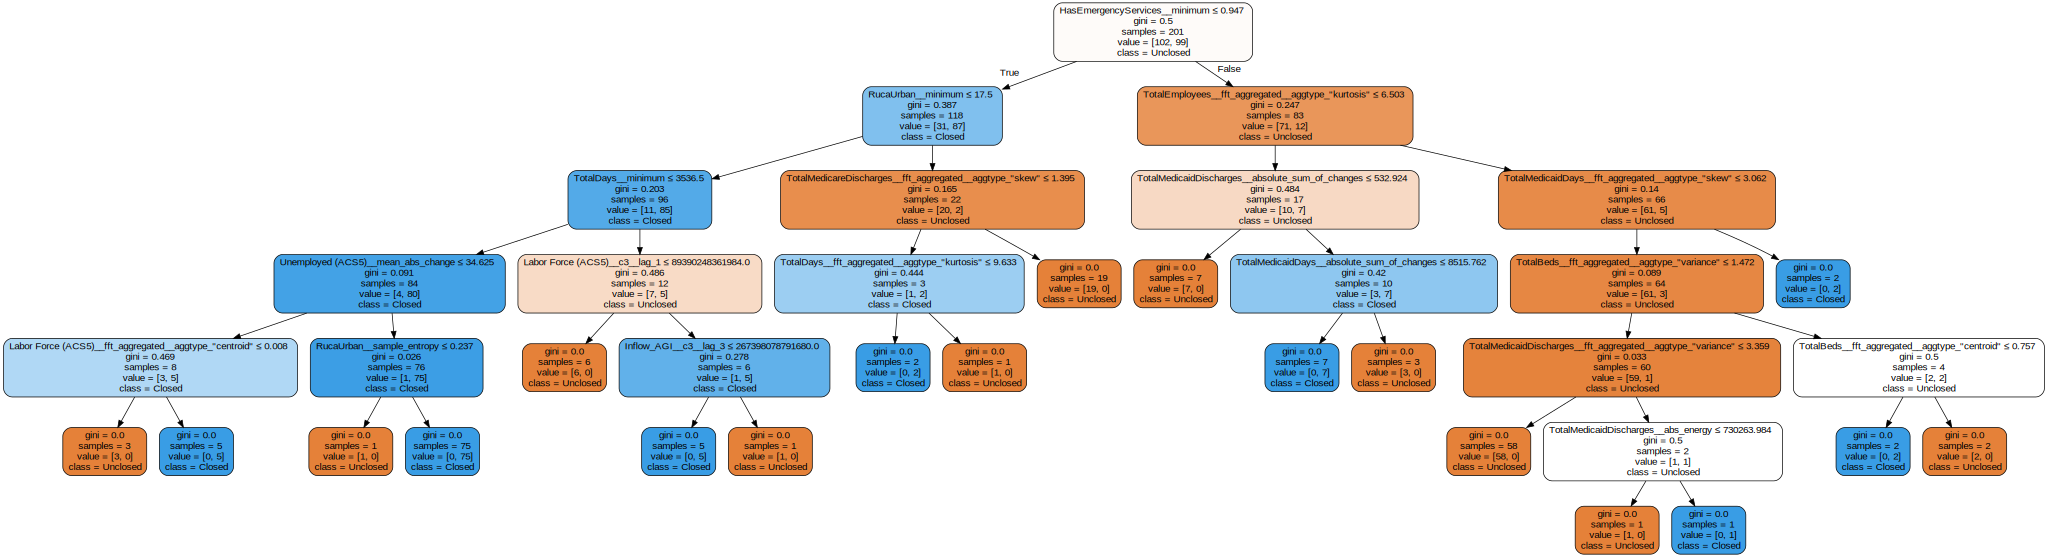

In [76]:
DTC_data = tree.export_graphviz(DTC, out_file=None,
                                feature_names=features_filtered_direct.columns,
                                class_names=['Unclosed', 'Closed'],
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(DTC_data)
graph

In [77]:
DTC.score(X_test[features_filtered_direct.columns], y_test)

0.7254901960784313

In [78]:
print(classification_report(y_test, DTC.predict(X_test[features_filtered_direct.columns])))

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73        24
         1.0       0.78      0.67      0.72        27

    accuracy                           0.73        51
   macro avg       0.73      0.73      0.73        51
weighted avg       0.73      0.73      0.73        51



In [79]:
perm = PermutationImportance(DTC, random_state=1).fit(X_test[features_filtered_direct.columns], y_test)
eli5.show_weights(perm, feature_names = X_test[features_filtered_direct.columns].columns.tolist())

Weight,Feature
0.1608 ± 0.0760,TotalDays__minimum
0.1137 ± 0.0760,HasEmergencyServices__minimum
0.0627 ± 0.0457,RucaUrban__minimum
0.0314 ± 0.0192,RucaUrban__sample_entropy
0.0235 ± 0.0293,Inflow_AGI__c3__lag_3
0.0078 ± 0.0192,"TotalMedicaidDischarges__fft_aggregated__aggtype_""variance"""
0.0078 ± 0.0314,Labor Force (ACS5)__c3__lag_1
0.0039 ± 0.0157,"TotalBeds__fft_aggregated__aggtype_""variance"""
0 ± 0.0000,Total Population (ACS5)__abs_energy
0 ± 0.0000,"TotalMedicareDischarges__fft_aggregated__aggtype_""kurtosis"""


- The use of the time series data does not seem to improved our model; in fact, it has gotten worse. It is possible that this is a case of overfitting.